In [154]:
import warnings
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import f90nml
import pandas as pd
import isca_tools
import matplotlib
from matplotlib.dates import ConciseDateConverter
from isca_tools.era5.get_jasmin_era5 import Find_era5
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
from isca_tools.utils.base import split_list_max_n
import os
print(os.getcwd())

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [2]:
# Attempt to load data from JASMIN but very slow
%%time
lat_loc = [60, 40, -24, 55]
lon_loc = [50., 355., 133.75, 290.]
loc_names = ['russia', 'spain', 'australia', 'canada']
year_use = 1995

era5 = Find_era5(archive=None)
var_keep = ['t', 'z', 'q']
var = era5[var_keep, f"{year_use}-06-01":f"{year_use}-09-01":'3h', None, lat_loc[0]-0.4:lat_loc[0]+0.4, lon_loc[0]-0.4:lon_loc[0]+0.4]     # 2m temperature
# var2 = era5[['t'], "2005-02-01":"2005-02-04", None, 0:3, 0:6]   # log of surface pressure

UsageError: Line magic function `%%time` not found.


In [189]:
# map of GRIB_shortName
era5_var_map = {
    "10m_u_component_of_wind": "10u",
    "10m_v_component_of_wind": "10v",
    "10m v-component of neutral wind": "v10n",
    "boundary_layer_height": "blh",
    "convective_inhibition": "cin",
    "convective_available_potential_energy": "cape",
    "2m_dewpoint_temperature": "2d",
    "2m_temperature": "2t",
    "volumetric_soil_water_layer_1": "swvl1",
    "convective_precipitation": "cp",
    "total_precipitation": "tp",
    "evaporation": "e",
    "total_cloud_cover": "tcc",
    "cloud_base_height": "cbh",
    "high_cloud_cover": "hcc",
    "low_cloud_cover": "lcc",
    "medium_cloud_cover": "mcc",
    "surface_latent_heat_flux": "slhf",
    "surface_sensible_heat_flux": "sshf",
    "surface_thermal_radiation_downward_clear_sky": "strd",
    "surface_thermal_radiation_downwards": "strd",
    "surface_solar_radiation_downwards": "ssrd",
    "surface_solar_radiation_downward_clear_sky": "ssrdc",
    "surface_net_solar_radiation": "ssr",
    "surface_net_solar_radiation_clear_sky": "ssrc",
    "surface_net_thermal_radiation": "str",
    "surface_net_thermal_radiation_clear_sky": "strc",
    "surface_pressure": "sp",
    "boundary_layer_dissipation": "bld",
    "instantaneous_moisture_flux": "ie"
}

## Convert GRIB to netCDF
The file format is GRIB which is a bit annoying, here we convert it to netCDF.

To do this, we need to re format variables with `step` variable so have same time axis as other variables.

In [458]:
dir_base = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/diurnal_play'
loc = 'russia'
nml_path = f'{dir_base}/{loc}/input_single_lev_local.nml'
grib_vars = f90nml.read(nml_path)['request']['variable']
grib_path = f'{dir_base}/{loc}/output_single_level_grib.nc'
times_all = xr.open_dataset(grib_path, engine="cfgrib",
                     filter_by_keys={'shortName': '2t'}).time.values  # select CIN specifically)

In [ ]:
def align_var_with_step(var, time_target):
    """
    Align a DataArray 'var' (time_var, step, ...) to a new time_target axis,
    so return 'var_align' (time_target, step, ...).
    Keeps all steps and extra dimensions, fills NaN where valid_time does not exist.

    Parameters
    ----------
    var : xarray.DataArray
        Dims: ('time', 'step', ...) with shape (len(time_var), n_step, ...)
            Contains 2D coordinate 'valid_time' (len(time_var) x n_step)
    time_target : array-like
        Target 1D times to align to.

    Returns
    -------
    out : xarray.DataArray
        Dims: ('time', 'step', ...) with shape (len(time_target), n_step, ...)
        NaNs where no match.
    """
    # Flatten time x step for indexing
    var_flat = var.stack(ts=("time", "step"))
    var_flat = var_flat.transpose('ts', ...)        # make ts first dimension
    valid_time_flat = var_flat.valid_time.values.flatten()  # shape (time*step)

    # Create output coordinates
    coords = {"valid_time": time_target, "step": var.step}
    extra_dims = [d for d in ds.dims if isinstance(d, str) and d not in ("time", "step")]
    for d in extra_dims:
        coords[d] = var.coords[d]

    # Create empty output filled with NaNs
    out_shape = (len(time_target), len(var.step)) + tuple(var.sizes[d] for d in extra_dims)
    out_data = np.full(out_shape, np.nan, dtype=var.dtype)
    out = xr.DataArray(out_data, coords=coords, dims=("valid_time", "step") + tuple(extra_dims))

    # Build mapping from valid_time_flat → time_target index
    time_idx_map = {t: i for i, t in enumerate(time_target)}

    # Map values
    for k, vt in enumerate(valid_time_flat):
        if vt in time_idx_map:
            i = time_idx_map[vt]
            j = k % len(var.step)  # step index
            out[i, j] = var_flat.values[k]  # broadcast over extra dims automatically

    out = out.rename({'valid_time': 'time'})        # rename valid_time as time
    return out

Number of non nan values at lat/lon. Should be the same
Original
 [[118 118 131 131]
 [126 133 133 152]
 [138 138 138 138]
 [151 142 142 147]
 [146 146 145 145]]
New
 [[118 118 131 131]
 [126 133 133 152]
 [138 138 138 138]
 [151 142 142 147]
 [146 146 145 145]]


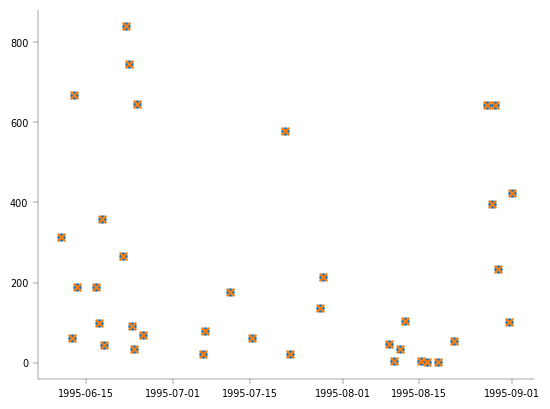

In [477]:
do_sanity_check = True
if do_sanity_check:
    # Sanity check with cin, re indexing variables
    ds = xr.open_dataset(grib_path, engine="cfgrib",
                         filter_by_keys={'shortName': 'cin'})
    ds = ds.load()
    ds_new = align_var_with_step(ds.cin, times_all)

    print('Number of non nan values at lat/lon. Should be the same')
    print('Original\n', (~np.isnan(ds.cin)).sum(dim=['time', 'step']).values)
    print('New\n', (~np.isnan(ds_new)).sum(dim=['time', 'step']).values)

    plt.scatter(ds_new.time, ds_new.isel(latitude=0, longitude=0, step=0), marker='.', s=100)
    plt.scatter(ds.valid_time.isel(step=0), ds.cin.isel(latitude=0, longitude=0, step=0), marker='x', s=30, lw=1.5)

In [490]:
ds_all = {}
for var in grib_vars:
    ds = xr.open_dataset(grib_path, engine="cfgrib",
                         filter_by_keys={'shortName': era5_var_map[var]})
    if len(ds)==0:
        warnings.warn(f"{var} does not exist")
        # print(ds)
        continue
    name = list(ds.data_vars)[0]
    ds = ds[name]      # convert to dataarray
    if 'step' in ds.dims:
        ds = align_var_with_step(ds, times_all)
    else:
        ds = ds.drop_vars(['step'])
    ds_all[name] = ds

ds_all = xr.Dataset(ds_all)
ds_all = ds_all.drop_vars('valid_time')
netcdf_path = f'{dir_base}/{loc}/output_single_level.nc'
# ds_all.to_netcdf(netcdf_path)

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60759/2240360404.py:6: UserWarning: 10m_u_component_of_wind does not exist
  warnings.warn(f"{var} does not exist")


In [500]:
ds_all.to_netcdf(netcdf_path)